In [342]:
import numpy as np
import pandas as pd
from collections import OrderedDict

import sklearn
import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducible results
SEED = 90
torch.manual_seed(SEED)
np.random.seed(SEED)

In [343]:
def sklearn_dataset():
    from sklearn import datasets
    diabetes = datasets.load_diabetes()
    diabetes_features = pd.DataFrame(diabetes.data)
    diabetes_targets = pd.DataFrame(diabetes.target)
    describe_dataset(diabetes_features)
    return diabetes_features,diabetes_targets

def load_csv(dataset_name:str):
    _data = pd.read_csv(dataset_name)
    describe_dataset(_data)
    return _data

def describe_dataset(_data):
    print("Dataset view (first 5 rows)")
    display(_data.head())
    print(f"Dataset dimensions: {_data.shape[0]} x {_data.shape[1]}\n")
    print("Dataset info\n")
    _data.info()
    print("\nDataset description\n")
    display(_data.describe(include='all'))
    print(f" Number of NaN entries: {sum(_data.isna().sum())}")
    print(f" Number of duplicated entries: {_data.duplicated().sum()}")

In [344]:
diabetes_1 = load_csv(dataset_name='diabetes.csv')

Dataset view (first 5 rows)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Dataset dimensions: 768 x 9

Dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Dataset description



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


 Number of NaN entries: 0
 Number of duplicated entries: 0


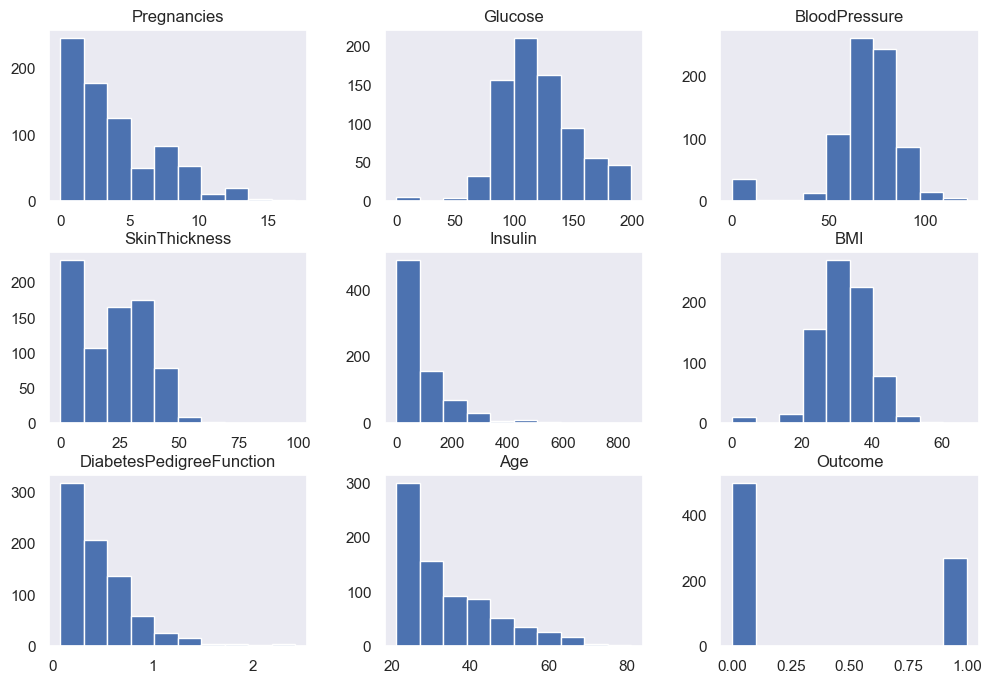

In [345]:
diabetes_1_plot = diabetes_1.hist(figsize=(12,8),grid=False)

In [346]:
diabetes_1.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [347]:
diabetes_1.shape

(768, 9)

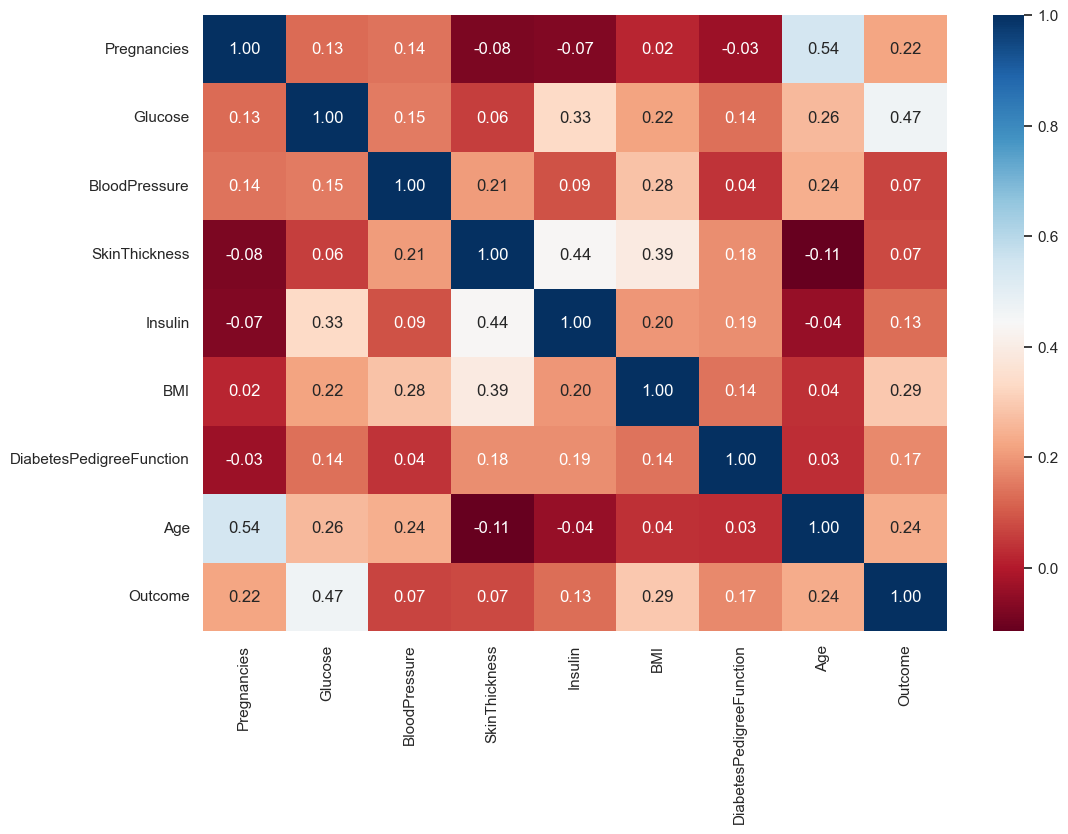

In [348]:
sns.set()
plt.figure(figsize=(12, 8))
db1_cfm = sns.heatmap(diabetes_1.corr(),cmap="RdBu",annot=True, fmt=".2f")

#### Infering data from graphs

- target values are unbalanced
- 2/5ths of the data doesn't have any information on smoking history

# Base Model

In [349]:
from sklearn.model_selection import train_test_split
db1_target = diabetes_1['Outcome']
db1_features = diabetes_1.drop(columns=['Outcome'])
X_train,X_test,y_train,y_test = train_test_split(db1_features,db1_target,test_size=0.2,random_state=SEED,shuffle=False)


In [350]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
pre_pl = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',StandardScaler())])

In [351]:
X_train = pre_pl.fit_transform(X_train)
X_test = pre_pl.fit_transform(X_test)

In [352]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# class Perceptron():
#     def __init__(self, num_features) -> None:
#         self.num_features = num_features
#         self.weights = torch.zeros((num_features,1),dtype=torch.float32, device=device)
#         self.bias = torch.zeros(1, dtype=torch.float32, device=device)
#         self.ones = torch.ones(1)
#         self.zeros = torch.zeros(1)

#     def forward(self, x):
#         linear = torch.add(torch.mm(x, self.weights), self.bias)
#         predictions = torch.where(linear > 0., self.ones, self.zeros)
#         return predictions
    
#     def backward(self, x, y):
#         predictions = self.forward(x)
#         errors = y - predictions
#         return errors
    
#     def train(self, x, y, epochs):
#         for e in range(epochs):
#             for i in range(y.shape[0]):
#             # use view because backward expects a matrix (i.e., 20 tensor)
#                 errors = self.backward(x[i].reshape(1,self.num_features),y[i]).reshape(-l)
#                 self.weights += (errors * x[i]).reshape(self.num_features,1)
#                 self.bias +=errors
    
#     def evaluate(self, x, y):
#         predictions = self.forward(x).reshape(-1)
#         accuracy = torch.sum(predictions==y).float() / y.shape[0]
#         return accuracy

#     def __str__(self) -> str:
#         return f"Weights: {self.weights}\nBias:{self.bias}\nOnes:{self.ones}\nZeros:{self.zeros}"

In [353]:
class Perceptron(nn.Module):
    def __init__(self, input_size=8):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, 1)
   
    def forward(self, x):
        return torch.sigmoid(self.fc1(x))

In [354]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Add hidden layers
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            self.hidden_layers.append(nn.ReLU())
            input_size = hidden_size

        self.output_layer = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return self.sigmoid(x)

In [355]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [356]:
def train(model, X, y, num_epochs, learning_rate, batch_size=20, verbose = True, graph=True):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    accuracy_history = []
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # BCELoss expects float labels
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted_labels = (outputs >= 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate accuracy and loss for this epoch
        accuracy = correct_predictions / total_samples
        loss_epoch = running_loss / len(dataloader)

        # Append to history
        accuracy_history.append(accuracy)
        loss_history.append(loss_epoch)

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")
    
    if verbose:
        print("Training Complete")
    if graph:
        graph_results(accuracy_history=accuracy_history,loss_history=loss_history, num_epochs=num_epochs)
    return model, accuracy_history, loss_history

    
def graph_results(accuracy_history, loss_history, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), accuracy_history, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), loss_history, label='Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    

from sklearn.metrics import accuracy_score

def evaluate_classification(predicted_labels, actual_labels, threshold=0.5):
    predicted_labels = (predicted_labels >= threshold).float()

    # Convert torch tensors to NumPy arrays for sklearn metrics
    predicted_labels = predicted_labels.numpy()
    actual_labels = actual_labels.numpy()

    # Calculating evaluation metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)


    metrics = {
        "Accuracy": accuracy
    }

    return metrics


Epoch 1, Loss: 0.7044999387956434
Epoch 2, Loss: 0.703920639330341
Epoch 3, Loss: 0.7036441199241146
Epoch 4, Loss: 0.703347344552317
Epoch 5, Loss: 0.7032822024437689
Epoch 6, Loss: 0.7020895115790828
Epoch 7, Loss: 0.7016288657342235
Epoch 8, Loss: 0.7011359603174271
Epoch 9, Loss: 0.7010016114481034
Epoch 10, Loss: 0.7010617044664198
Epoch 11, Loss: 0.7000440301433686
Epoch 12, Loss: 0.6999014692921792
Epoch 13, Loss: 0.7000136202381503
Epoch 14, Loss: 0.6994944695503481
Epoch 15, Loss: 0.6984040218014871
Epoch 16, Loss: 0.6982983408435699
Epoch 17, Loss: 0.6983420291254597
Epoch 18, Loss: 0.6973787219293656
Epoch 19, Loss: 0.6974003968700286
Epoch 20, Loss: 0.6967293350927292
Epoch 21, Loss: 0.6967426423103579
Epoch 22, Loss: 0.695592091929528
Epoch 23, Loss: 0.6951886011708167
Epoch 24, Loss: 0.6951158738905384
Epoch 25, Loss: 0.6945881612839238
Epoch 26, Loss: 0.6949039447692132
Epoch 27, Loss: 0.6941563794689793
Epoch 28, Loss: 0.6930937459391933
Epoch 29, Loss: 0.69436104451456

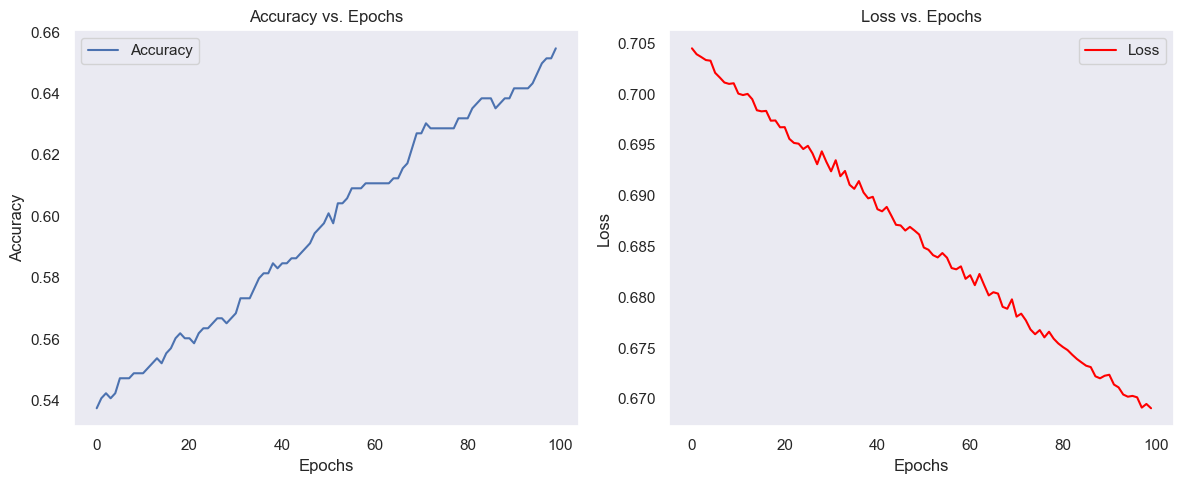

{'Accuracy': 0.6948051948051948}

In [357]:
n_epochs = 100
batch_size = 20
model = Perceptron()
trained_model, accuracy_history, loss_history = train(model=model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.0001, batch_size=batch_size)
y_pred = trained_model(X_test)
evaluate_classification(y_pred, y_test)

Epoch 1, Loss: 0.7067008787585843
Epoch 2, Loss: 0.7058132194703625
Epoch 3, Loss: 0.704656470206476
Epoch 4, Loss: 0.7039853084471918
Epoch 5, Loss: 0.7031837567206352
Epoch 6, Loss: 0.7016121399018073
Epoch 7, Loss: 0.7010617929120218
Epoch 8, Loss: 0.7004519912504381
Epoch 9, Loss: 0.6994164701431028
Epoch 10, Loss: 0.6980566747726933
Epoch 11, Loss: 0.6972541770627422
Epoch 12, Loss: 0.6972318503164476
Epoch 13, Loss: 0.6960943072072922
Epoch 14, Loss: 0.6952656545946675
Epoch 15, Loss: 0.694091058546497
Epoch 16, Loss: 0.6934067280061783
Epoch 17, Loss: 0.6926262705556808
Epoch 18, Loss: 0.6920292742790715
Epoch 19, Loss: 0.6906607381759151
Epoch 20, Loss: 0.6897757284102901
Epoch 21, Loss: 0.6890371307249992
Epoch 22, Loss: 0.6887539990486637
Epoch 23, Loss: 0.6876394902506182
Epoch 24, Loss: 0.6869643734347436
Epoch 25, Loss: 0.6858679152304127
Epoch 26, Loss: 0.684851102290615
Epoch 27, Loss: 0.684192955493927
Epoch 28, Loss: 0.6840686798095703
Epoch 29, Loss: 0.682685190631497

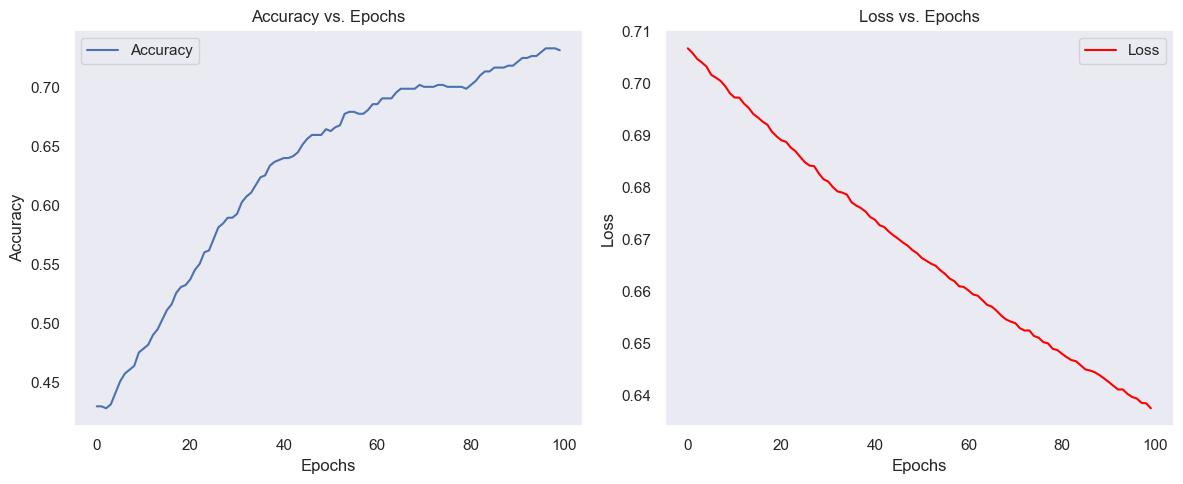

{'Accuracy': 0.7727272727272727}

In [358]:
n_epochs = 100
batch_size = 20
mlp_model = MLP(input_size=8,hidden_sizes=[64],output_size=1)
mlp_trained_model, mlp_accuracy_history, mlp_loss_history = train(model=mlp_model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.0001, batch_size=batch_size)
mlp_y_pred = mlp_trained_model(X_test)
evaluate_classification(predicted_labels=mlp_y_pred,actual_labels=y_test)

Summary for the baseline model

|Model|Accuracy|Final Loss|
|-|-|-|
|Single Layer|0.69|0.67|
|Multi Layer (2)|0.71|0.66|

From the above we can conclude that the 2 layer model is marginally better than the single layer model, taking this into consideration we will furtherr tune the multi-layer model to further improve the results.

# Tuning Model

In [320]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import make_scorer
from itertools import product
        
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP2, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Add hidden layers
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            self.hidden_layers.append(nn.ReLU())
            input_size = hidden_size

        self.output_layer = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return self.sigmoid(x)
    

def tune_mlp(X, y,Xt,yt,param_grid):
    input_size = X.shape[1]
    output_size = 1
    
    # Define hyperparameters to search
    all_combinations = list(product(*param_grid.values()))
    
    # Create the MLP model
    combination_results = {}
    for parameter_combination,counter in zip(all_combinations,range(len(all_combinations))):
        _hidden_sizes = parameter_combination[0]
        _model = MLP2(input_size, _hidden_sizes, output_size)
        _learning_rate = parameter_combination[1]
        _batch_size = parameter_combination[2]
        _n_epochs = parameter_combination[3]
        trained_model, accuracy_history, loss_history = train(model=_model, X=X, y=y, num_epochs=_n_epochs, learning_rate=_learning_rate, batch_size=_batch_size,verbose=False,graph=False)
        _mlp_y_pred = trained_model(Xt)
        _accuracy = evaluate_classification(predicted_labels=_mlp_y_pred,actual_labels=yt)
        combination_results[counter] = {'combination':{'hidden_sizes':_hidden_sizes,'learning_rate':_learning_rate,'batch_size':_batch_size,'num_epochs':_n_epochs},'accuracy':_accuracy['Accuracy']}
    
    combination_results = pd.DataFrame.from_dict(combination_results,orient='index')
    best_result = combination_results[combination_results['accuracy'] == combination_results['accuracy'].max()]
    if len(best_result)>1:
        return tune_mlp(X, y,Xt,yt,param_grid)
    
    return best_result


In [321]:
param_grid = {
        'hidden_sizes': [ [16, 8], [32, 16], [64,32]],
        'learning_rate': [0.01, 0.1, 0.05],
        'batch_size': [16, 32],
        'num_epochs': [10,20]
    }

best_res = tune_mlp(X=X_train,y=y_train,Xt=X_test,yt=y_test,param_grid=param_grid)

In [376]:
all_combinations = list(product(*param_grid.values()))
len(all_combinations)

36

In [322]:
best_res.values 

array([[{'hidden_sizes': [32, 16], 'learning_rate': 0.1, 'batch_size': 16, 'num_epochs': 20},
        0.8051948051948052]], dtype=object)

Epoch 1, Loss: 0.6351514955361685
Epoch 2, Loss: 0.5397700743797498
Epoch 3, Loss: 0.488406723126387
Epoch 4, Loss: 0.4672304624930406
Epoch 5, Loss: 0.4656265255732414
Epoch 6, Loss: 0.4573002854983012
Epoch 7, Loss: 0.4580493714564886
Epoch 8, Loss: 0.45019529645259565
Epoch 9, Loss: 0.4407870333928328
Epoch 10, Loss: 0.44891288723701084
Epoch 11, Loss: 0.4419121986780411
Epoch 12, Loss: 0.43789054911870223
Epoch 13, Loss: 0.4339680155882469
Epoch 14, Loss: 0.43808934818475675
Epoch 15, Loss: 0.4381450166304906
Epoch 16, Loss: 0.42981201295669264
Epoch 17, Loss: 0.4289403137488243
Epoch 18, Loss: 0.4278438179156719
Epoch 19, Loss: 0.42676970209830845
Epoch 20, Loss: 0.4237146786390207
Training Complete


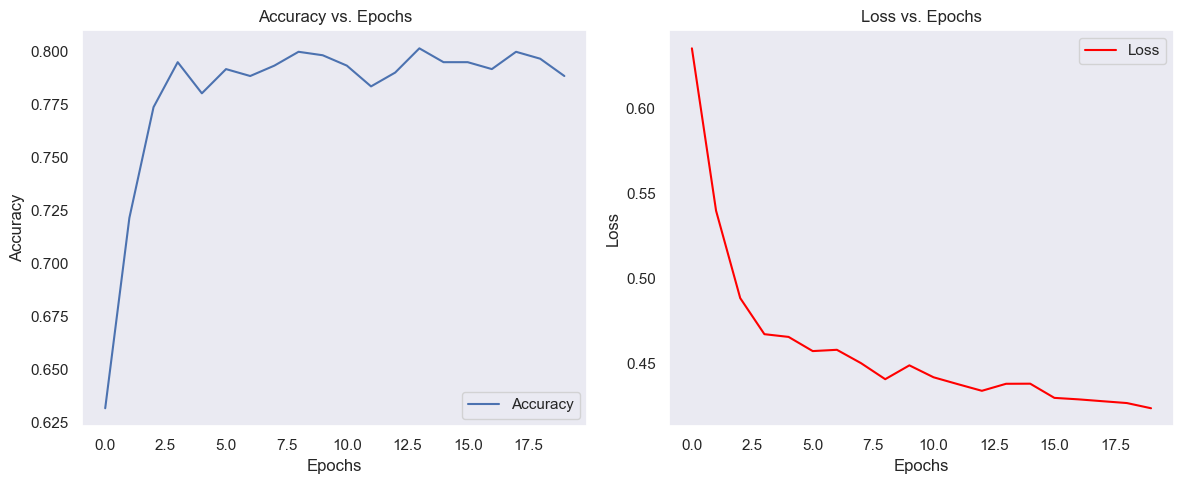

{'Accuracy': 0.7857142857142857}

In [393]:
n_epochs = 20
batch_size = 16
mlp_model = MLP2(input_size=8,hidden_sizes=[32, 16],output_size=1)
mlp_trained_model, mlp_accuracy_history, mlp_loss_history = train(model=mlp_model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.1, batch_size=batch_size)
mlp_y_pred = mlp_trained_model(X_test)
evaluate_classification(predicted_labels=mlp_y_pred,actual_labels=y_test)

In [394]:
x = mlp_trained_model(X_train) # Training Accuracy for epoch 20
evaluate_classification(predicted_labels=x,actual_labels=y_train)

{'Accuracy': 0.8078175895765473}

Epoch 1, Loss: 0.6473974875914745
Epoch 2, Loss: 0.549764837209995
Epoch 3, Loss: 0.5005621719054687
Epoch 4, Loss: 0.4846203151421669
Epoch 5, Loss: 0.47386007469434005
Epoch 6, Loss: 0.4724371868830461
Epoch 7, Loss: 0.4642894825874231
Epoch 8, Loss: 0.46102149326067704
Epoch 9, Loss: 0.4568945605021257
Epoch 10, Loss: 0.445716760861568
Epoch 11, Loss: 0.45974566768377256
Epoch 12, Loss: 0.4536674141119688
Epoch 13, Loss: 0.44458294678957033
Epoch 14, Loss: 0.44339012450132614
Epoch 15, Loss: 0.43746167765213895
Epoch 16, Loss: 0.4356841070529742
Epoch 17, Loss: 0.435235348267433
Epoch 18, Loss: 0.43739111912556183
Epoch 19, Loss: 0.4286697751436478
Epoch 20, Loss: 0.4338725507259369
Epoch 21, Loss: 0.4226528264773198
Epoch 22, Loss: 0.42072170705367357
Epoch 23, Loss: 0.4242026213652048
Epoch 24, Loss: 0.4182305133495575
Epoch 25, Loss: 0.4176988315123778
Epoch 26, Loss: 0.4158746328873512
Epoch 27, Loss: 0.4103355422998086
Epoch 28, Loss: 0.40882917799246615
Epoch 29, Loss: 0.41341

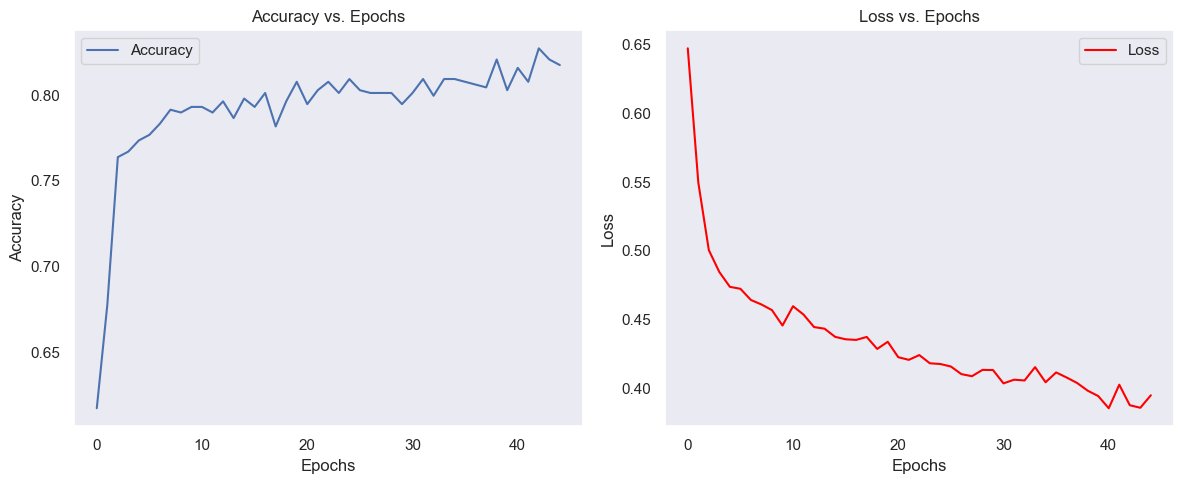

{'Accuracy': 0.8181818181818182}

In [420]:
n_epochs = 45
batch_size = 16
mlp_model = MLP2(input_size=8,hidden_sizes=[32, 16],output_size=1)
mlp_trained_model, mlp_accuracy_history, mlp_loss_history = train(model=mlp_model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.1, batch_size=batch_size)
mlp_y_pred = mlp_trained_model(X_test)
evaluate_classification(predicted_labels=mlp_y_pred,actual_labels=y_test)

In [421]:
x = mlp_trained_model(X_train) # Training Accuracy for epoch 45
evaluate_classification(predicted_labels=x,actual_labels=y_train)

{'Accuracy': 0.8257328990228013}

Epoch 1, Loss: 0.686618658212515
Epoch 2, Loss: 0.6347869581136948
Epoch 3, Loss: 0.5985702245663373
Epoch 4, Loss: 0.5437595660869892
Epoch 5, Loss: 0.5003433303955274
Epoch 6, Loss: 0.4736838531799806
Epoch 7, Loss: 0.46936915585627925
Epoch 8, Loss: 0.46236173999615204
Epoch 9, Loss: 0.45496254089551097
Epoch 10, Loss: 0.4503961736575151
Epoch 11, Loss: 0.4534607460865608
Epoch 12, Loss: 0.4412708213696113
Epoch 13, Loss: 0.436199291012226
Epoch 14, Loss: 0.43846760269923085
Epoch 15, Loss: 0.4326933885996158
Epoch 16, Loss: 0.4341071958725269
Epoch 17, Loss: 0.43531687825154036
Epoch 18, Loss: 0.42945913091684
Epoch 19, Loss: 0.4293775661633565
Epoch 20, Loss: 0.425795058791454
Epoch 21, Loss: 0.4305815291710389
Epoch 22, Loss: 0.42541070397083575
Epoch 23, Loss: 0.43101018820053494
Epoch 24, Loss: 0.4216175507276486
Epoch 25, Loss: 0.4253316464332434
Epoch 26, Loss: 0.42261547805407107
Epoch 27, Loss: 0.4205159109372359
Epoch 28, Loss: 0.4164714645116757
Epoch 29, Loss: 0.42141265

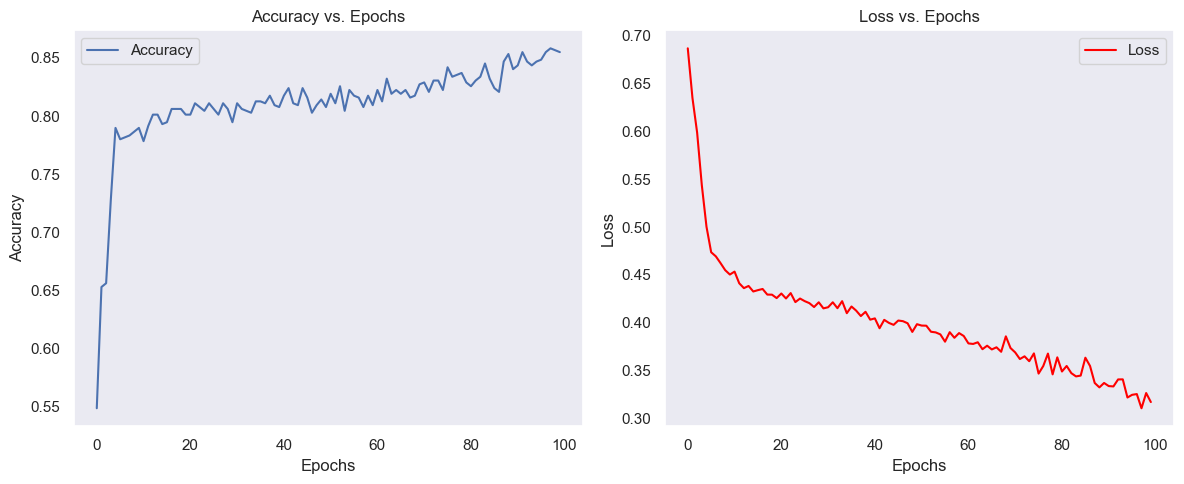

{'Accuracy': 0.7597402597402597}

In [391]:
n_epochs = 100
batch_size = 16
mlp_model = MLP2(input_size=8,hidden_sizes=[32, 16],output_size=1)
mlp_trained_model, mlp_accuracy_history, mlp_loss_history = train(model=mlp_model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.1, batch_size=batch_size)
mlp_y_pred = mlp_trained_model(X_test)
evaluate_classification(predicted_labels=mlp_y_pred,actual_labels=y_test)

In [392]:
x = mlp_trained_model(X_train) # Training Accuracy for epoch 100
evaluate_classification(predicted_labels=x,actual_labels=y_train)

{'Accuracy': 0.8599348534201955}

# Statistical Inference